# PREPARE DATASET

In [33]:
import sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# sys.path.insert(0,"..")
from dataloader import dataloader
#device = torch.device("cuda")
tmp = dataloader(r"..\data\clover")
imu, rotor, mocap = tmp.runPipeline()
tmp.homogenizeData()
data = tmp.ConcatData
#print(device)


  0%|          | 0/1 [00:00<?, ?it/s]

[INFO]  Data folder c:\Users\prana\Documents\DeepIO\data\clover\New folder\New folder\rosbag already exists. Not creating.


100%|██████████| 1/1 [00:24<00:00, 24.59s/it]


In [34]:
data['g_x'] = 0.0
data['g_y'] = 0.0
data['g_z'] = -9.81


In [76]:
sensor_readings = data[['linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z',
                        'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z', 'g_x', 'g_y', 'g_z']].to_numpy()
sensor_readings = torch.tensor(sensor_readings,dtype=torch.float32)#, device=device)
sensor_readings = sensor_readings[:100000,:]
sensor_readings.shape


torch.Size([100000, 9])

In [77]:
eulers = data[['phi', 'theta', 'psi']].to_numpy()
eulers = torch.tensor(eulers,dtype=torch.float32)#, device=device)
eulers = eulers[:100000,:]


# Neural net architectures

In [78]:
class euler_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(9, 30, dtype=torch.float64)
        self.layer2 = nn.Linear(30, 30, dtype=torch.float64)
        self.layer3 = nn.Linear(30, 3, dtype=torch.float64)
        self.tanh = nn.Tanh()

    def forward(self, sensor_reading):
        x = self.tanh(self.layer1(sensor_reading))
        x = self.tanh(self.layer2(x))
        x = self.layer3(x)
        return x


In [48]:
EulerModel = euler_model()#.to(device)


In [55]:
lr = 0.01
dataset = torch.utils.data.TensorDataset(sensor_readings, eulers)
train_set, test_set = torch.utils.data.random_split(
    dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
optimizer = torch.optim.Adam(EulerModel.parameters(), lr=lr)
dataloader = torch.utils.data.DataLoader(
    train_set, batch_size=4000, shuffle=True)
loss_fn = nn.MSELoss()
losses = []

epoch_num = 1000
# axa,y,az,gx,-9.81
for epoch in range(epoch_num):
    for batch in dataloader:
        sensor_reading, euler = batch
        prediction = EulerModel(sensor_readings)
        loss = loss_fn(prediction, eulers)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

fig = plt.figure()
plt.plot(losses)
plt.show()


Epoch: 0, Loss: 0.04521732650533726
Epoch: 100, Loss: 0.032116925170205445


KeyboardInterrupt: 

In [58]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

SensorTF = tf.convert_to_tensor(sensor_readings,dtype=tf.float32)
eulerTF = tf.convert_to_tensor(eulers,dtype=tf.float32)
#XTr, Xt, YTr ,Yt = train_test_split(SensorTF, eulerTF, test_size=0.2)

model = tf.keras.models.Sequential([tf.keras.layers.Input((9, 1)),
                    tf.keras.layers.GRU(128),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(3)])

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  ema_momentum=0.8), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.fit(SensorTF[:75000,:], eulerTF[:75000,:], validation_data=(SensorTF[75000:,:], eulerTF[75000:,:]), epochs=1000)

Epoch 1/1000
2344/2344 [==============================] - 14s 5ms/step - loss: 0.1004 - root_mean_squared_error: 0.3168 - val_loss: 0.0835 - val_root_mean_squared_error: 0.2889
Epoch 2/1000
2344/2344 [==============================] - 12s 5ms/step - loss: 0.0496 - root_mean_squared_error: 0.2226 - val_loss: 0.0633 - val_root_mean_squared_error: 0.2517
Epoch 3/1000
2344/2344 [==============================] - 12s 5ms/step - loss: 0.0333 - root_mean_squared_error: 0.1824 - val_loss: 0.0525 - val_root_mean_squared_error: 0.2291
Epoch 4/1000
2344/2344 [==============================] - 12s 5ms/step - loss: 0.0239 - root_mean_squared_error: 0.1545 - val_loss: 0.0519 - val_root_mean_squared_error: 0.2278
Epoch 5/1000
2344/2344 [==============================] - 12s 5ms/step - loss: 0.0179 - root_mean_squared_error: 0.1337 - val_loss: 0.0538 - val_root_mean_squared_error: 0.2320
Epoch 6/1000
2344/2344 [==============================] - 12s 5ms/step - loss: 0.0147 - root_mean_squared_error: 0.

KeyboardInterrupt: 

In [133]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

SensorTF = tf.convert_to_tensor(sensor_readings,dtype=tf.float32)
eulerTF = tf.convert_to_tensor(eulers,dtype=tf.float32)
#XTr, Xt, YTr ,Yt = train_test_split(SensorTF, eulerTF, test_size=0.2)

model2 = tf.keras.models.Sequential([tf.keras.layers.Input((9, 1)),
                    tf.keras.layers.LSTM(128,activation='relu'),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(3)])

model2.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  ema_momentum=0.8), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model2.fit(SensorTF[:75000,:], eulerTF[:75000,:], validation_data=(SensorTF[75000:,:], eulerTF[75000:,:]), epochs=200)

Epoch 1/200
2344/2344 [==============================] - 26s 10ms/step - loss: 0.1217 - root_mean_squared_error: 0.3489 - val_loss: 0.1016 - val_root_mean_squared_error: 0.3188
Epoch 2/200
2344/2344 [==============================] - 23s 10ms/step - loss: 0.0691 - root_mean_squared_error: 0.2628 - val_loss: 0.0838 - val_root_mean_squared_error: 0.2895
Epoch 3/200
2344/2344 [==============================] - 23s 10ms/step - loss: 0.0531 - root_mean_squared_error: 0.2305 - val_loss: 0.0695 - val_root_mean_squared_error: 0.2636
Epoch 4/200
2344/2344 [==============================] - 23s 10ms/step - loss: 0.0440 - root_mean_squared_error: 0.2097 - val_loss: 0.0627 - val_root_mean_squared_error: 0.2504
Epoch 5/200
2344/2344 [==============================] - 23s 10ms/step - loss: 0.0363 - root_mean_squared_error: 0.1906 - val_loss: 0.0658 - val_root_mean_squared_error: 0.2565
Epoch 6/200
2344/2344 [==============================] - 23s 10ms/step - loss: 0.0305 - root_mean_squared_error: 0.

KeyboardInterrupt: 

In [112]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.call = nn.Sequential(

            nn.Conv1d(9, 32, kernel_size=1),#, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2),

            nn.Conv1d(32, 64, kernel_size=1),#, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.4),

            #nn.MaxPool1d(kernel_size=2),

            nn.Flatten(),

            nn.Linear(64, 128),
            nn.ReLU(),

            nn.Linear(128, 3)
        )
        self.call = self.call.float()

    def forward(self, x):
        x = x.reshape(-1, 9, 1)
        x = self.call(x)
        return x

In [122]:
# 1D CNN neural network

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils

BatchSize = 2000
model_m = Sequential()
model_m.add(Reshape((BatchSize, 3, 3), input_shape=(BatchSize,9)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(BatchSize, 3, 3)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Dropout(0.3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(3, activation='relu'))

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(SensorTF, eulerTF, batch_size=BatchSize,
                      epochs=EPOCHS,
                      validation_split=0.2,
                      verbose=1)

ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv1d_12. Consider increasing the input size. Received input shape [None, 2000, 3, 3] which would produce output shape with a zero or negative value in a dimension.

In [119]:
model_m.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 1991, 100)         9100      
                                                                 
 conv1d_7 (Conv1D)           (None, 1982, 100)         100100    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 660, 100)         0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 660, 100)          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 651, 160)          160160    
                                                                 
 conv1d_9 (Conv1D)           (None, 642, 160)          256160    
                                                      

In [ ]:
sensor_readings

In [125]:
from resnet import Net1D
ConvModel = Net1D(9,3,0.8,[32,64,3],[32,32,32],3,1,1,3,False,True,False)

lr = 0.01
#ConvModel = ConvNet()#.to(device)
dataset = torch.utils.data.TensorDataset(sensor_readings, eulers)
train_set, test_set = torch.utils.data.random_split(
    dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
optimizer = torch.optim.Adam(ConvModel.parameters(), lr=lr)
dataloader = torch.utils.data.DataLoader(
    train_set, batch_size=4000, shuffle=True)
loss_fn = nn.MSELoss()
losses = []

epoch_num = 1000
# axa,y,az,gx,-9.81
for epoch in range(epoch_num):
    for batch in dataloader:
        sensor_reading, euler = batch
        prediction = ConvModel(sensor_readings)
        loss = loss_fn(prediction, eulers)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

fig = plt.figure()
plt.plot(losses)
plt.show()


ValueError: in_channels must be divisible by groups

# Scientific Deep learning methods

In [141]:
X_train, y_train = sensor_readings[:60000,:].numpy(), eulers[:60000,:].numpy()
X_test, y_test = sensor_readings[60000:,:].numpy(), eulers[60000:,:].numpy()

import deepxde as dde
Data = dde.data.DataSet(X_train, y_train, X_test, y_test)

net = dde.nn.ResNet(9,3,128*3, 5,activation = "tanh", kernel_initializer="Glorot normal")
model = dde.Model(Data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=50000)


Compiling model...
Building residual neural network...
'build' took 0.354214 s

'compile' took 1.274524 s

Initializing variables...
Training model...

0         [1.83e+00]    [1.89e+00]    [1.41e+00]    


KeyboardInterrupt: 

In [143]:
X_train, y_train = sensor_readings[:60000,:].numpy(), eulers[:60000,:].numpy()
X_test, y_test = sensor_readings[60000:,:].numpy(), eulers[60000:,:].numpy()

import deepxde as dde
Data = dde.data.DataSet(X_train, y_train, X_test, y_test)

net = dde.nn.PFNN([[30,30,1],[30,30,1],[30,30,1]], activation = "tanh", kernel_initializer="Glorot normal")
model = dde.Model(Data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=50000)

Compiling model...
Building feed-forward neural network...


TypeError: Error converting shape to a TensorShape: Dimension value must be integer or None or have an __index__ method, got value '[30, 30, 1]' with type '<class 'list'>'.

In [21]:
print(np.shape(X_train[0]))
np.shape(X_train[1])

torch.Size([9, 60, 100])


(100, 1)

In [27]:


class euler_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(9, 30)
        self.layer2 = nn.Linear(30, 30)
        self.layer3 = nn.Linear(30, 3)
        self.tanh = nn.Tanh()

    def forward(self, sensor_reading):
        x = self.tanh(self.layer1(sensor_reading))
        x = self.tanh(self.layer2(x))
        x = self.layer3(x)
        return x

class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(9, 35),
            nn.LeakyReLU(),
            nn.Linear(35, 35),
            nn.LeakyReLU(),
            nn.Linear(35, 3),
        )
        #self.net = self.net.float()
        self.net.apply(self._apply_wt_init)

    def forward(self, t, y):
        print(y.dtype)
        return self.net(y)
    
    def _apply_wt_init(self, layer):
        if isinstance(layer, nn.Linear):
            print(layer.weight.dtype)
            nn.init.normal_(layer.weight, mean=0, std=0.1)
            nn.init.constant_(layer.bias, val=0)
              
m = 100
dim_x = 9
net = dde.nn.deeponet.DeepONet(
    (100, euler_model()),
    [9, 30,30,3], 
    "relu",
    "Glorot normal",
)

NODEModel = ODEFunc()#.to(device)

#Define a Model
model = dde.Model(Data, net)

# Compile and Train
model.compile("adam", lr=0.0005, metrics=["mean l2 relative error"])
losshistory, train_state = model.train(iterations=50000)


Compiling model...
Building DeepONet...


TypeError: linear(): argument 'input' (position 1) must be Tensor, not Tensor

In [32]:
from torchdiffeq import odeint_adjoint as odeint
def CreateBatch(yTrain, xTrain, size, batch_size, batch_time):
        
    s = torch.from_numpy(np.random.choice(np.arange(size-batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = yTrain[s,:]
    batch_x = np.array([0,1])#xTrain[:batch_time] 
    batch_y = xTrain[s,:]#torch.stack([torch.Tensor(yTrain[s + i,:]) for i in range(batch_time)], dim=0)

    return batch_y0, batch_x, batch_y

lr = 0.01
dataset = torch.utils.data.TensorDataset(sensor_readings, eulers)
train_set, test_set = torch.utils.data.random_split(
    dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
optimizer = torch.optim.Adam(EulerModel.parameters(), lr=lr)
dataloader = torch.utils.data.DataLoader(
    train_set, batch_size=10000, shuffle=True)
loss_fn = nn.MSELoss()
losses = []

epoch_num = 1000
# axa,y,az,gx,-9.81
for epoch in range(epoch_num):
    #for batch in dataloader:
    #sensor_reading, euler = batch
    t = np.array([0,1])

    batch_y0, batch_x, batch_y = CreateBatch(sensor_reading, eulers, np.shape(sensor_reading)[0], 1000, 2)
    pred_y = odeint(EulerModel, torch.Tensor(batch_y0).to(torch.float64), torch.Tensor(batch_x), method='dopri5')
        
    loss = torch.mean(torch.abs(pred_y - batch_y))

        #loss = loss_fn(prediction, eulers)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

fig = plt.figure()
plt.plot(losses)
plt.show()

RuntimeError: The size of tensor a (3) must match the size of tensor b (9) at non-singleton dimension 1

# Results

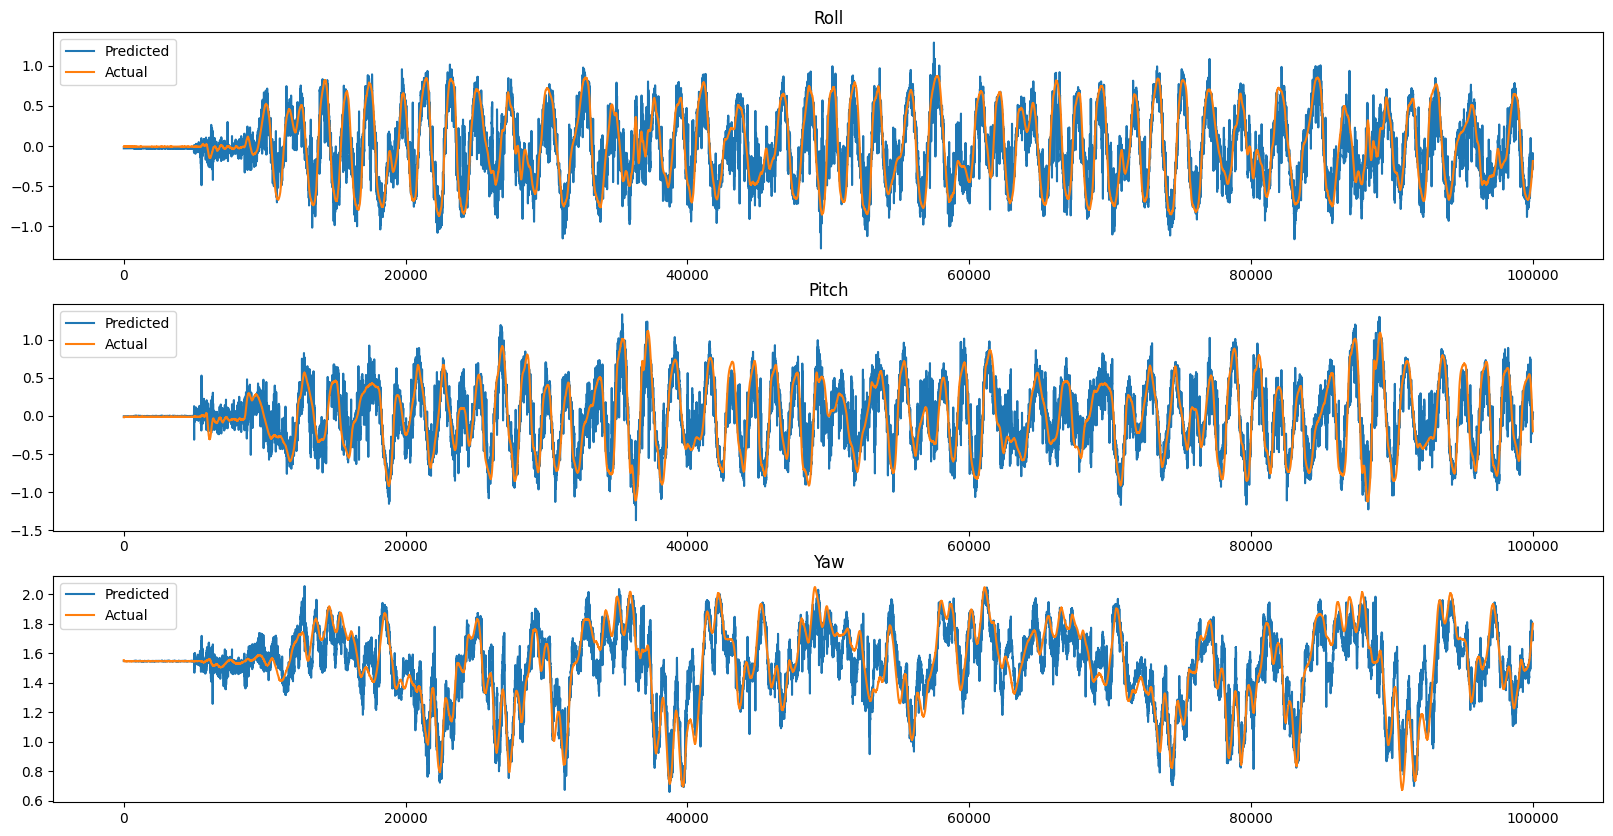

In [60]:
#%matplotlib widget
EulerModel.eval()
# sensor_readings, eulers = test_set[:]
with torch.no_grad():
    prediction = EulerModel(sensor_readings)

fig, axs = plt.subplots(3, 1, figsize=(20, 10))

axs[0].plot(prediction[:, 0].cpu().numpy(), label='Predicted')
axs[0].plot(eulers[:, 0].cpu().numpy(), label='Actual')
axs[0].set_title('Roll')
axs[0].legend()

axs[1].plot(prediction[:, 1].cpu().numpy(), label='Predicted')
axs[1].plot(eulers[:, 1].cpu().numpy(), label='Actual')
axs[1].set_title('Pitch')
axs[1].legend()

axs[2].plot(prediction[:, 2].cpu().numpy(), label='Predicted')
axs[2].plot(eulers[:, 2].cpu().numpy(), label='Actual')
axs[2].set_title('Yaw')
axs[2].legend()

plt.show()


Instructions for updating:
Use tf.identity instead.


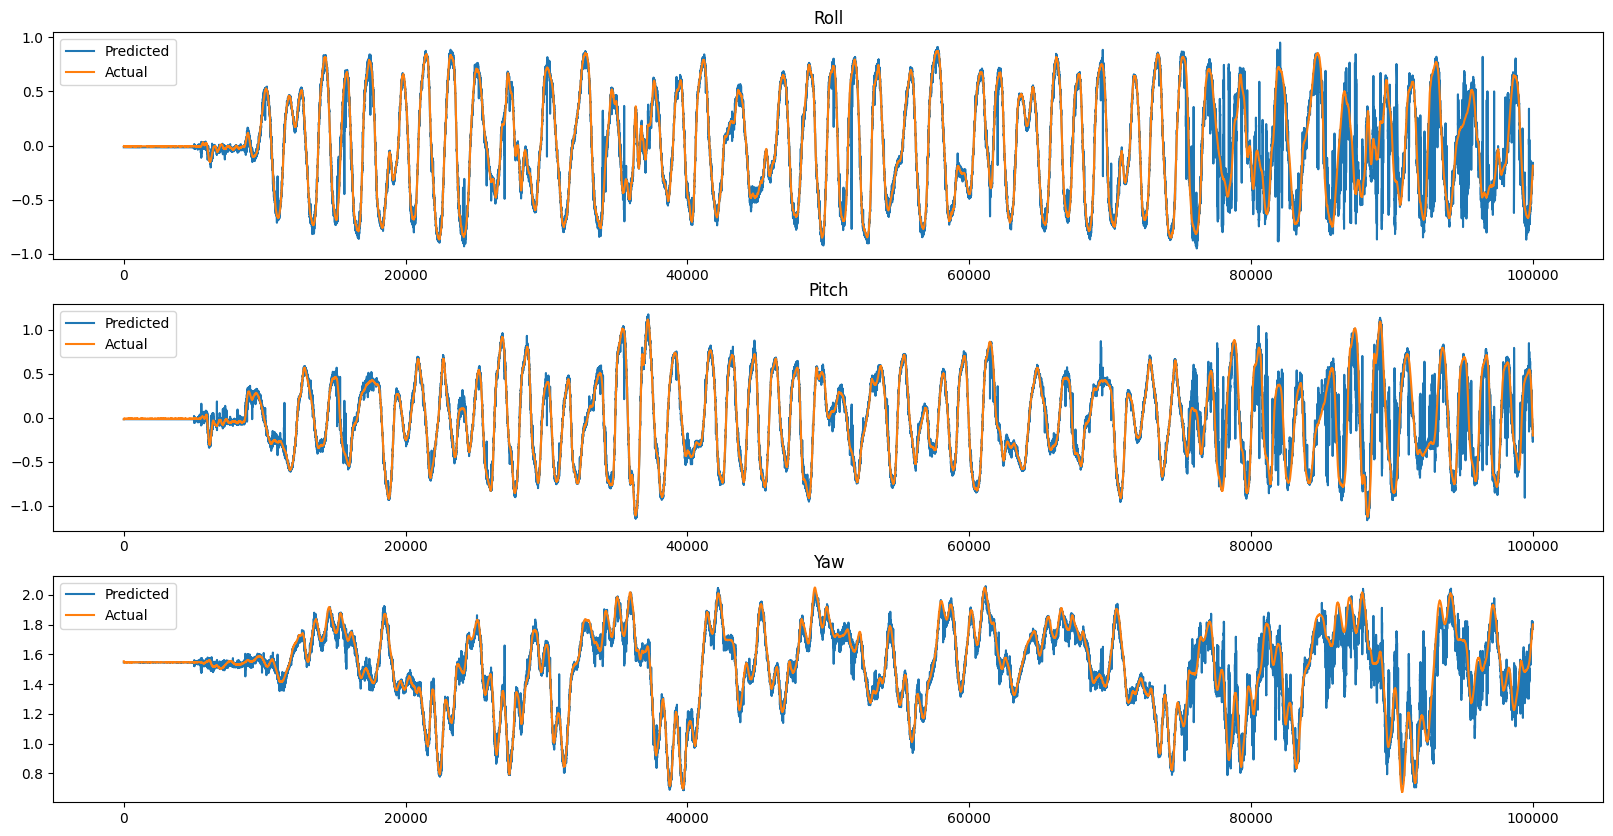

In [64]:
#%matplotlib widget
#model.eval()
# sensor_readings, eulers = test_set[:]
with torch.no_grad():
    prediction = model(SensorTF)

fig, axs = plt.subplots(3, 1, figsize=(20, 10))

axs[0].plot(prediction[:, 0].cpu().numpy(), label='Predicted')
axs[0].plot(eulers[:, 0].cpu().numpy(), label='Actual')
axs[0].set_title('Roll')
axs[0].legend()

axs[1].plot(prediction[:, 1].cpu().numpy(), label='Predicted')
axs[1].plot(eulers[:, 1].cpu().numpy(), label='Actual')
axs[1].set_title('Pitch')
axs[1].legend()

axs[2].plot(prediction[:, 2].cpu().numpy(), label='Predicted')
axs[2].plot(eulers[:, 2].cpu().numpy(), label='Actual')
axs[2].set_title('Yaw')
axs[2].legend()

plt.show()


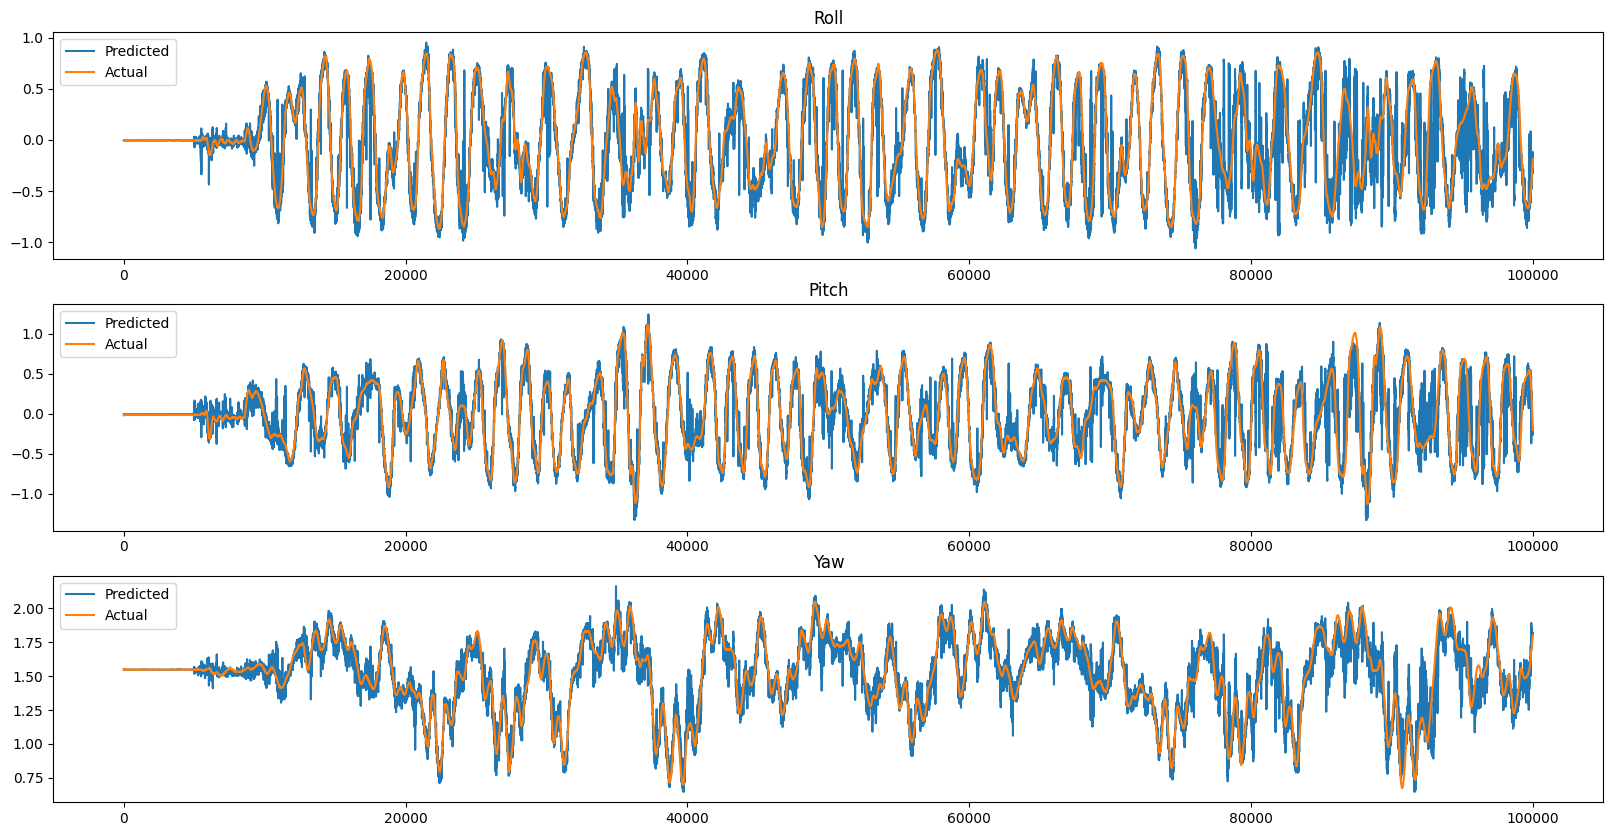

In [130]:
with torch.no_grad():
    prediction = model2(SensorTF)

fig, axs = plt.subplots(3, 1, figsize=(20, 10))

axs[0].plot(prediction[:, 0].cpu().numpy(), label='Predicted')
axs[0].plot(eulers[:, 0].cpu().numpy(), label='Actual')
axs[0].set_title('Roll')
axs[0].legend()

axs[1].plot(prediction[:, 1].cpu().numpy(), label='Predicted')
axs[1].plot(eulers[:, 1].cpu().numpy(), label='Actual')
axs[1].set_title('Pitch')
axs[1].legend()

axs[2].plot(prediction[:, 2].cpu().numpy(), label='Predicted')
axs[2].plot(eulers[:, 2].cpu().numpy(), label='Actual')
axs[2].set_title('Yaw')
axs[2].legend()

plt.show()

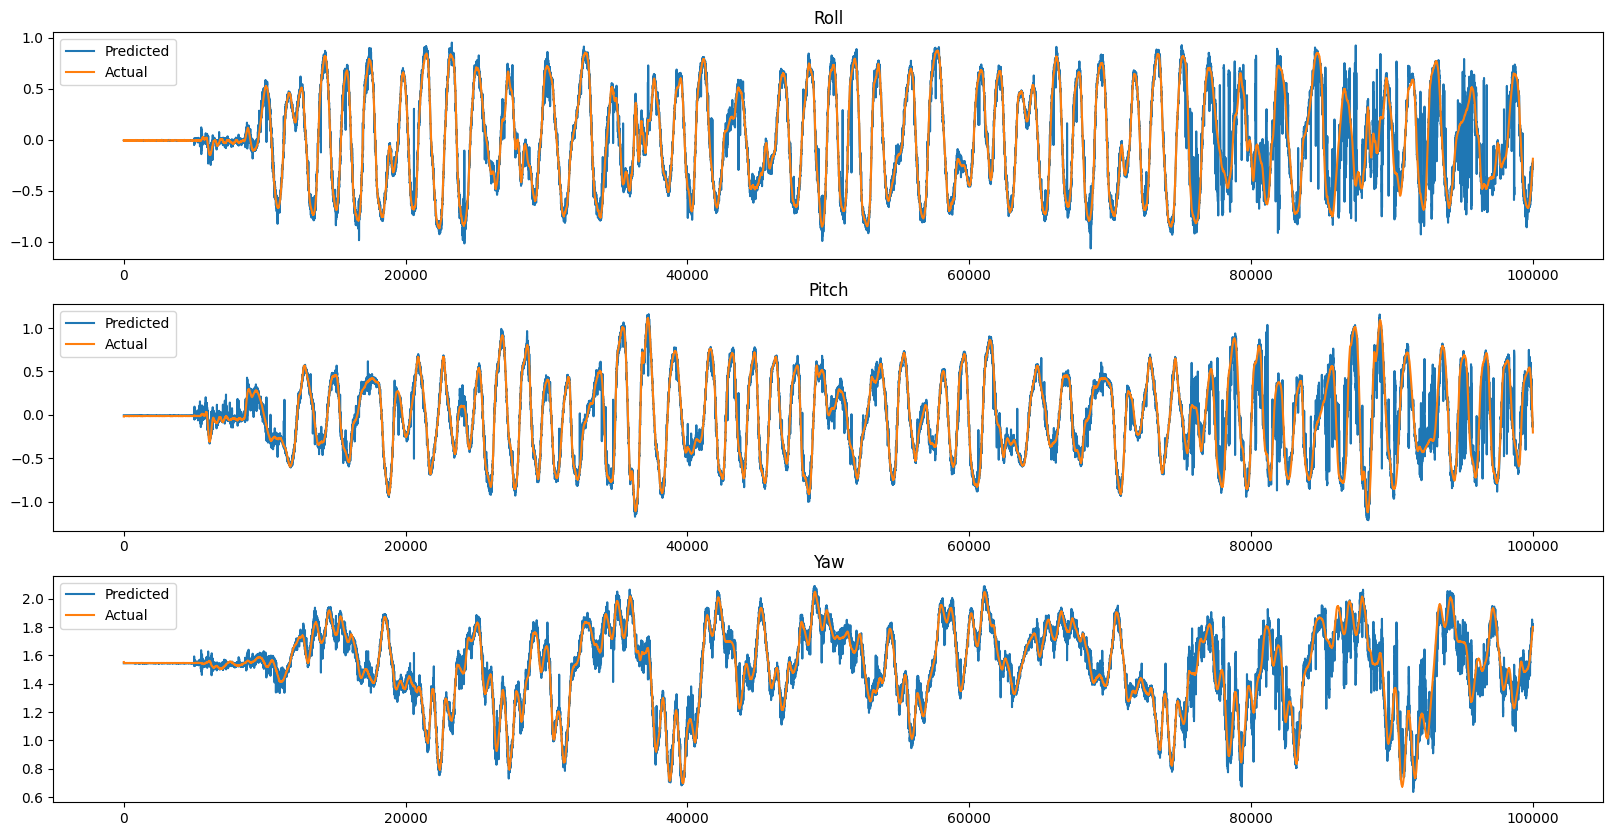

In [134]:
with torch.no_grad():
    prediction = model2(SensorTF)

fig, axs = plt.subplots(3, 1, figsize=(20, 10))

axs[0].plot(prediction[:, 0].cpu().numpy(), label='Predicted')
axs[0].plot(eulers[:, 0].cpu().numpy(), label='Actual')
axs[0].set_title('Roll')
axs[0].legend()

axs[1].plot(prediction[:, 1].cpu().numpy(), label='Predicted')
axs[1].plot(eulers[:, 1].cpu().numpy(), label='Actual')
axs[1].set_title('Pitch')
axs[1].legend()

axs[2].plot(prediction[:, 2].cpu().numpy(), label='Predicted')
axs[2].plot(eulers[:, 2].cpu().numpy(), label='Actual')
axs[2].set_title('Yaw')
axs[2].legend()

plt.show()

# SCRAP

In [ ]:
# import matplotlib.pyplot as plt


# x1, y1, z1 = data['pose.position.x'].to_numpy(
# ), data['pose.position.y'].to_numpy(), data['pose.position.z'].to_numpy()
# xA1, yA1, zA1 = data['psi'].to_numpy(
# ), data['theta'].to_numpy(), data['phi'].to_numpy()
# dt = np.append(0, np.diff(data['Time'].to_numpy()))
# r1, r2, r3, r4 = data['rpm_0'].to_numpy(), data['rpm_1'].to_numpy(
# ), data['rpm_2'].to_numpy(), data['rpm_3'].to_numpy()


# TrajectorySize = 25000  # 15*350
# TrainTrajectorySize = int(0.8*TrajectorySize)
# St = 0  # Start index


# xTrain = np.stack((r1[St:St + TrajectorySize], r2[St:St + TrajectorySize],
#                   r3[St:St + TrajectorySize], r4[St:St + TrajectorySize], dt[St:St + TrajectorySize]), axis=1)
# yTrain = np.stack((x1[St:St + TrajectorySize], y1[St:St + TrajectorySize], z1[St:St + TrajectorySize],
#                    xA1[St:St + TrajectorySize], yA1[St:St + TrajectorySize], zA1[St:St + TrajectorySize]), axis=1)


# # torch.tensor(xTrain[:7000], dtype=torch.float32)
# train_x = xTrain[:TrainTrajectorySize]
# # torch.tensor(yTrain[:7000], dtype=torch.float32)
# train_y = yTrain[:TrainTrajectorySize]
# # torch.tensor(xTrain[7000:], dtype=torch.float32)
# test_x = xTrain[TrainTrajectorySize:]
# # torch.tensor(yTrain[7000:], dtype=torch.float32)
# test_y = yTrain[TrainTrajectorySize:]

# xTrain = torch.tensor(xTrain, device=device)
# yTrain = torch.tensor(yTrain, device=device)
# train_x = torch.tensor(train_x, device=device)
# train_y = torch.tensor(train_y, device=device)
# test_x = torch.tensor(test_x, device=device)
# test_y = torch.tensor(test_y, device=device)

# ax = plt.figure().add_subplot(projection='3d')
# ax.plot(train_y[:, 0].cpu().numpy(), train_y[:, 1].cpu(
# ).numpy(), train_y[:, 2].cpu().numpy(), '.b')


In [ ]:
# #### NODE #####

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchdiffeq import odeint_adjoint as odeint
# import numpy as np
# import matplotlib.pyplot as plt

# method = 'dopri5'
# batch_time = 45
# batch_size = TrainTrajectorySize-100
# niters = 200000
# test_freq = 10000
# viz = 'store_true'
# adjoint = 'store_true'


# # def mini_batch(yTrain, xTrain, size, batch_size, batch_time):

# #     s = torch.from_numpy(np.random.choice(
# #         np.arange(size-batch_time, dtype=np.int64), batch_size, replace=False))
# #     batch_y0 = xTrain[s, :4]
# #     batch_x = xTrain[:batch_time, 4]
# #     batch_y = torch.stack([torch.Tensor(xTrain[s + i, :4])
# #                           for i in range(batch_time)], dim=0)
# #     batch_yy = yTrain[s, :]
# #     batch_yy1 = yTrain[s+1, :]

# #     return batch_y0, batch_x, batch_y, batch_yy, batch_yy1

# def mini_batch(yTrain, xTrain, size, batch_size, batch_time):
#     device = torch.device("cuda")
#     s = torch.randint(0, size-batch_time, (batch_size,),
#                       dtype=torch.int64, device=device)
#     batch_y0 = xTrain[s, :4]
#     batch_x = xTrain[:batch_time, 4]
#     batch_y = torch.stack([xTrain[s + i, :4]
#                           for i in range(batch_time)], dim=0)
#     batch_yy = yTrain[s, :]
#     batch_yy1 = yTrain[s+1, :]

#     return batch_y0, batch_x, batch_y, batch_yy, batch_yy1

# # def TrainNODENetwork(yTrain, xTrain, size, batch_size, batch_time, FuncControl, FuncDynamics, niters=13000,):

# #     parameters = list(FuncControl.parameters()) + \
# #         list(FuncDynamics.parameters())
# #     # optimizerD = optim.Adam(params=parameters, lr=1e-3)
# #     optimizer = optim.Adadelta(
# #         params=parameters, lr=1, rho=0.9, eps=1e-06, weight_decay=0)

# #     for itr in range(1, niters + 1):
# #         optimizer.zero_grad()
# #         batch_y0, batch_x, batch_y, batch_yy, batch_yy1 = mini_batch(
# #             yTrain, xTrain, size, batch_size, batch_time)
# #         # pred_y = odeint(FuncControl, torch.Tensor(
# #             # batch_y0).to(device = 'cuda:0'), torch.Tensor(batch_x))

# #         XDynamics = torch.cat((batch_y0, batch_yy), 1).to(
# #             device='cuda:0')  # pred_y[1,:,:]
# #         pred_yy = FuncDynamics(XDynamics).to(device='cuda:0', dtype=torch.float64)
# #         lossD = torch.mean(
# #             torch.abs(pred_yy - batch_yy1))
# #         # lossC = torch.mean(torch.abs(pred_y - torch.Tensor(batch_y)))

# #         loss = lossD  # + lossC
# #         loss.backward()
# #         optimizer.step()

# #         if itr % test_freq == 0:
# #             '''with torch.no_grad():
# #                 pred_y = odeint(Func, torch.Tensor(y0[1,:]), t)
# #                 loss = torch.norm(pred_y - torch.Tensor(y[:,1,:]))'''
# #             print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

# #     return FuncControl, FuncDynamics


# class ODEFunc(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(4, 30),
#             nn.ReLU(),
#             nn.Linear(30, 30),
#             nn.ReLU(),
#             nn.Linear(30, 4),
#         )
#         self.net = self.net.float()
#         self.net.apply(self._apply_wt_init)

#     def forward(self, t, y):
#         return self.net(y)

#     def _apply_wt_init(self, layer):
#         if isinstance(layer, nn.Linear):
#             nn.init.normal_(layer.weight, mean=0, std=0.1)
#             nn.init.constant_(layer.bias, val=0)


# class Func2(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.net = nn.Sequential(
#             # nn.BatchNorm1d(10),
#             nn.Linear(10, 175),
#             nn.LeakyReLU(),
#             nn.BatchNorm1d(175),
#             nn.Linear(175, 35),
#             nn.LeakyReLU(),
#             nn.BatchNorm1d(35),
#             nn.Linear(35, 6),
#         )
#         self.net = self.net.to(dtype=torch.float64)
#         self.net.apply(self._apply_wt_init)

#     def forward(self, y):
#         return self.net(y)

#     def _apply_wt_init(self, layer):
#         if isinstance(layer, nn.Linear):
#             nn.init.normal_(layer.weight, mean=0, std=0.1)
#             nn.init.constant_(layer.bias, val=0)


# FuncControl = ODEFunc().to(device=device)
# FuncDynamics = Func2().to(device=device)

# train_y = torch.tensor(train_y, device=device)
# train_x = torch.tensor(train_x, device=device)


# # FuncControl, FuncDynamics = TrainNODENetwork(
# #     train_y, train_x, TrainTrajectorySize, batch_size, batch_time, FuncControl, FuncDynamics)


In [ ]:
# parameters = list(FuncControl.parameters()) + list(FuncDynamics.parameters())
# optimizer = optim.Adadelta(params=parameters, lr=0.1,
#                            rho=0.9, eps=1e-06, weight_decay=0)

# batchy0s = []
# batchxs = []
# batchys = []
# batchyys = []
# batchyy1s = []

# # for itr in range(1, niters + 1):
# #     batch_y0, batch_x, batch_y, batch_yy, batch_yy1 = mini_batch(
# #         yTrain, xTrain, TrainTrajectorySize, batch_size, batch_time)
# #     batchy0s.append(batch_y0)
# #     batchxs.append(batch_x)
# #     batchys.append(batch_y)
# #     batchyys.append(batch_yy)
# #     batchyy1s.append(batch_yy1)
# niters = 5000
# test_freq = 1000
# for itr in range(1, niters + 1):
#     optimizer.zero_grad()
#     # batch_y0 = batchy0s[itr-1]
#     # batch_x = batchxs[itr-1]
#     # batch_y = batchys[itr-1]
#     # batch_yy = batchyys[itr-1]
#     # batch_yy1 = batchyy1s[itr-1]

#     batch_y0, batch_x, batch_y, batch_yy, batch_yy1 = mini_batch(
#         yTrain, xTrain, TrainTrajectorySize, batch_size, batch_time)

#     XDynamics = torch.cat([batch_y0, batch_yy], dim=1)
#     pred_yy = FuncDynamics(XDynamics)
#     loss = torch.mean(torch.abs(pred_yy - batch_yy1))

#     loss.backward()
#     optimizer.step()

#     if itr % test_freq == 0:
#         print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))


In [ ]:
# from copy import deepcopy


In [ ]:
# %matplotlib widget
# ax = plt.figure().add_subplot(projection='3d')
# ax.plot(train_y[::2, 0].cpu().detach().numpy(), train_y[::2, 1].cpu(
# ).detach().numpy(), train_y[::2, 2].cpu().detach().numpy(), '.r')

# y0 = train_y[0, :]
# u0 = train_x[0, :4]
# FuncDynamics.eval()
# x = []
# y = []
# z = []
# for i in range(TrainTrajectorySize):

#     # pred_u = odeint(FuncControl, torch.Tensor(u0), torch.Tensor(train_x[i:i+5,4]))

#     u0 = train_x[i, :4]  # pred_u[1,:].detach().numpy()
#     if i % 500 == 0:
#         m = deepcopy(train_y[i, :])

#         # m[0] += (np.random.uniform()-0.5)
#         # m[1] += (np.random.uniform()-0.5)
#         # m[2] += (np.random.uniform()-0.5)
#     else:
#         m = pred_y
#     # print("In",m)
#     XDynamics = torch.cat(
#         (torch.Tensor(u0), torch.Tensor(m).to(device='cuda:0'))).to(device='cuda:0').unsqueeze(0)
#     pred_y = FuncDynamics(XDynamics).flatten()
#     y0 = pred_y.to('cpu').detach().numpy()
#     # print("Out:", y0)
#     # if i == 5:
#     #     break
#     x.append(y0[0])
#     y.append(y0[1])
#     z.append(y0[2])

# ax.scatter(x[0::2], y[::2], z[::2], s=8, c='b')
# plt.xlim([-5, 5])
# plt.ylim([-5, 5])
# plt.gca().set_zlim([-5, 0])
# plt.show()


In [ ]:
# %matplotlib widget
# plt.figure()
# xt = []
# yt = []
# zt = []

# y0 = train_y[0, :]
# u0 = train_x[0, :4]
# FuncDynamics.eval()
# x = []
# y = []
# z = []
# for i in range(TrainTrajectorySize):

#     # pred_u = odeint(FuncControl, torch.Tensor(u0), torch.Tensor(train_x[i:i+5,4]))

#     u0 = train_x[i, :4]  # pred_u[1,:].detach().numpy()
#     if i % 500 == 0:
#         m = deepcopy(train_y[i, :])

#         # m[0] += (np.random.uniform()-0.5)
#         # m[1] += (np.random.uniform()-0.5)
#         # m[2] += (np.random.uniform()-0.5)
#     else:
#         m = pred_y
#     # print("In",m)
#     XDynamics = torch.cat(
#         (torch.Tensor(u0), torch.Tensor(m).to(device='cuda:0'))).to(device='cuda:0').unsqueeze(0)
#     pred_y = FuncDynamics(XDynamics).flatten()
#     y0 = pred_y.to('cpu').detach().numpy()
#     y0[3:] = np.arctan2(np.sin(y0[3:]), np.cos(y0[3:]))
#     # print("Out:", y0)
#     # if i == 5:
#     #     break
#     x.append(y0[3])
#     y.append(y0[4])
#     z.append(y0[5])
#     xt.append(train_y[i, 3].cpu().detach().numpy())
#     yt.append(train_y[i, 4].cpu().detach().numpy())
#     zt.append(train_y[i, 5].cpu().detach().numpy())

# plt.plot(np.array(xt)*10, 'r')
# plt.plot(x, 'b')


# plt.show()


In [ ]:
# plt.figure()
# plt.plot(yt, 'r')
# plt.plot(y, 'b')
# plt.show()


In [ ]:
# plt.figure()
# plt.plot(yt, 'r')
# plt.plot(y, 'b')
# plt.show()


In [ ]:
# torch.save(FuncDynamics.state_dict(), 'FuncDynamics2.pt')


In [ ]:
# loadModel = Func2().to(device=device)


In [ ]:
# loadModel.load_state_dict(torch.load('FuncDynamics.pt'))


In [ ]:
# loadModel.eval()
# ax = plt.figure().add_subplot(projection='3d')
# ax.plot(train_y[::2, 0].cpu().detach().numpy(), train_y[::2, 1].cpu(
# ).detach().numpy(), train_y[::2, 2].cpu().detach().numpy(), '.r')

# y0 = train_y[0, :]
# u0 = train_x[0, :4]
# FuncDynamics.eval()
# x = []
# y = []
# z = []
# for i in range(TrainTrajectorySize):

#     # pred_u = odeint(FuncControl, torch.Tensor(u0), torch.Tensor(train_x[i:i+5,4]))
#     u0 = train_x[i, :4]  # pred_u[1,:].detach().numpy()
#     m = deepcopy(train_y[i, :])
#     m[0] += (np.random.uniform()-0.5)*3
#     m[1] += (np.random.uniform()-0.5)*3
#     m[2] += (np.random.uniform()-0.5)*3
#     XDynamics = torch.cat(
#         (torch.Tensor(u0), torch.Tensor(m).to(device='cuda:0'))).to(device='cuda:0').unsqueeze(0)
#     pred_y = loadModel(XDynamics).flatten()
#     y0 = pred_y.to('cpu').detach().numpy()
#     x.append(y0[0])
#     y.append(y0[1])
#     z.append(y0[2])

# ax.scatter(x[0::2], y[::2], z[::2], s=8, c='b')
# plt.xlim([-5, 5])
# plt.ylim([-5, 5])
# plt.gca().set_zlim([-5, 0])
# plt.show()
